# 3 - Assigning Work

This is a continuation of the previous notebooks that were used to configure a new Workforce Project and import assignments. 

Many organizations would like to automatically dispatch work orders based on some algorithm. In this guide, we'll demonstrate how to assign workers to assignments with three different approaches:
1. Based on the location of the assignment within pre-defined zones
2. Based on the network drive time from current workers to the new assignments
3. Based on the work-load of workers out in the field

This guide uses the ArcGIS API for Python version 1.5.1 with Python 3.6+.

### Fetching the Project
Let's import the ArcGIS API for Python and find the project we previously configured.

In [1]:
from arcgis.gis import GIS
from arcgis.apps import workforce

gis = GIS("https://arcgis.com", "workforce_scripts")
project = workforce.Project(gis.content.search("type:'Workforce Project' 'Public Works Work Orders'")[0])

Enter password: ········


### Assigning assignments based on pre-defined zones
Let's assign all of the "Paint Crosswalk" assignments based on the city council district in which they are located. For each crosswalk that needs to be painted, we'll either assign it to Aaron or James. If it falls within district 3 we'll assign it to James. If instead it falls within district 8 we'll assign it to Aaron.

Note: This section requires that the current Python Environment has [arcpy](http://pro.arcgis.com/en/pro-app/arcpy/main/arcgis-pro-arcpy-reference.htm) or [shapely](https://github.com/Toblerity/Shapely) installed.

<Item title:"San Diego City Council Districts" type:Feature Layer Collection owner:workforce_scripts>
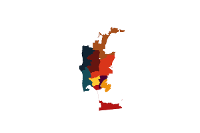

In [2]:
districts_item = gis.content.get("08eecb2f46c740aaba316cef8a719a88")
districts_item

First, let's fetch Aaron and James from the project, so we can assign assignments to them.

In [3]:
aaron = project.workers.get(user_id="aaron_nitro")
james = project.workers.get(user_id="james_nitro")

Next, we'll fetch the third and eighth district from the districts layer and convert the result to a spatially enabled dataframe.

In [4]:
districts_df = districts_item.layers[0].query("district in (3,8)").sdf

Then we'll search for all unassigned "Paint Crosswalk" assignments.

In [5]:
paint_crosswalk = project.assignment_types.get(name="Paint Crosswalk")
assignments = project.assignments.search(f"status=0 AND assignmentType={paint_crosswalk.code}")

For each assignment we'll determine if it lies within either district 3 or 8. If the assignment is within district 3, we'll assign it to James. If the assignment falls within district 8, we'll assign it to Aaron. Otherwise we'll leave the assignment unassigned.

In [6]:
from arcgis.geometry import Geometry
from datetime import datetime

for assignment in assignments:
    contains = districts_df["SHAPE"].geom.contains(Geometry(assignment.geometry))
    containers = districts_df[contains]
    if not containers.empty: 
        district = containers['district'].iloc[0]
        if district == 3:
            assignment.worker = james
            assignment.status = "assigned"
            assignment.assigned_date = datetime.utcnow()
        elif district == 8:
            assignment.worker = aaron
            assignment.status = "assigned"
            assignment.assigned_date = datetime.utcnow()

Now that the assignments have been assigned locally, we'll push those changes to the server.

In [7]:
assignments = project.assignments.batch_update(assignments)

### Assigning based on network drive time
Let's assign all of the "Fill in Pothole" assignments to the nearest working worker.
First, we need to create a function to calculate the network travel time between two points. In this function, we'll use the default routing service provided by the organization to create a [RouteLayer](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.network.toc.html#routelayer) object. We'll add the first point as the starting location and the second point as the ending location. We will solve this route to determine the total time it will take to travel between the two locations.

In [8]:
from arcgis.network import RouteLayer

def calculate_route_time(p1, p2, gis):
    route_layer = RouteLayer(gis.properties["helperServices"]["route"]["url"], gis)
    if 'spatialReference' not in p1:
        p1 = {'x': p1['x'], 'y': p1['y'], 'spatialReference': {'wkid': 102100}}
    if 'spatialReference' not in p2:
        p2 = {'x': p2['x'], 'y': p2['y'], 'spatialReference': {'wkid': 102100}}
    stops = {
        'features': [
            {'geometry': p1, 'attributes': {'Name': 'start'}},
            {'geometry': p2, 'attributes': {'Name': 'end'}}
        ]
    }
    try:
        route = route_layer.solve(stops, out_sr=102100, directions_length_units="esriNAUMeters")
        return route["directions"][0]["summary"]["totalTime"]
    except Exception as e:
        return sys.maxsize

Next let's fetch all of the active workers.

In [9]:
workers = project.workers.search("status=1")

Let's also fetch all of the unassigned "Fill in Pothole" assignments.

In [10]:
fill_in_pothole = project.assignment_types.get(name="Fill in Pothole")
assignments = project.assignments.search(f"status=0 AND assignmentType='{fill_in_pothole.code}'")

Now we'll iterate over all of the assignments and calculate the travel time between the assignment and all workers. We'll then sort the travel times of each worker and assign the first worker in the sorted list to the assignment.

In [11]:
for assignment in assignments:
    distances = []
    for worker in workers:
        route_time = calculate_route_time(worker.geometry, assignment.geometry, gis)
        distances.append({"worker": worker, "time": route_time})
    assignment.worker = sorted(distances, key=lambda x: x["time"])[0]["worker"]
    assignment.assigned_date = datetime.utcnow()
    assignment.status = "assigned"

Now that the assignments have been assigned locally, we'll push those changes to the server.

In [12]:
assignments = project.assignments.batch_update(assignments)

### Assigning based on workload of worker
Let's assign the "Sidewalk Repair" assignments to workers who have the fewest assignments. This way the total workload is evenly distributed. First let's fetch all of the unassigned sidewalk repair assignments.

In [13]:
sidwalk_repair = project.assignment_types.get(name="Sidewalk Repair")
assignments = project.assignments.search(f"status=0 AND assignmentType='{sidwalk_repair.code}'")

Next, let's calculate the workload of each worker and store it in a list of dictionaries.

In [14]:
workloads = []
for worker in workers:
    number_of_assignments = len(project.assignments.search(where=f"workerId='{worker.id}' AND status in (1,2,5)"))
    workloads.append({"worker": worker, "workload": number_of_assignments})

Now we'll iterate over the assignments and assign the worker who has the fewest assignments. We'll also increment that workers workload by one.

In [15]:
for assignment in assignments:
    worker_dict = sorted(workloads, key=lambda x: x["workload"])[0]
    assignment.worker = worker_dict["worker"]
    assignment.assigned_date = datetime.utcnow()
    assignment.status = "assigned"
    worker_dict["workload"] += 1

Now that the assignments have been assigned locally, we'll push those changes to the server.

In [16]:
assignments = project.assignments.batch_update(assignments)

### Summary
We just demonstrated three different ways to assign workers to assignments. There are many other algorithms that could be used to assign work. A couple example of more advanced methods that we've seen include:
1. Assigning based on the skill set of the worker (e.g. an Inspector only does Inspection assignments and a Plumber only does Plumbing assignments).
2. Assigning based on a combination of travel time and current workload.

The possibilities are nearly endless!